In [2]:
## Load the data
import math
import pandas as pd
import numpy as np
import seaborn as sns  
import datetime as dt   
sns.set()
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from google.colab import drive 
drive.mount("/content/gdrive", force_remount=True)
path = "/content/gdrive/MyDrive/elula_assignment/"
taxi = pd.read_csv(path+"taxi_dataFare.csv")
taxi.columns = [col.strip().replace(' ', '') for col in taxi.columns]
taxi = taxi.drop('Unnamed:0', axis=1)
#hr_employ = pd.read_csv(path+"hr_employ.csv")
#hr_employ.columns = [col.strip().replace(' ', '') for col in hr_employ.columns]
#hr_employ.drop(columns=hr_employ.columns[0], axis=1, inplace=True)
from geopy.geocoders import Nominatim
geolocator = Nominatim()

taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'])
taxi['DayofWeek'] = taxi.pickup_datetime.dt.day_name()
taxi['Pick_Hour'] = taxi.pickup_datetime.dt.hour
taxi['pick_date'] = taxi.pickup_datetime.dt.date
taxi['drop_date'] = taxi.pickup_datetime.dt.date
duration = (pd.to_datetime(taxi['dropoff_datetime']) - pd.to_datetime(taxi['pickup_datetime']))/np.timedelta64(1, 's')
taxi['in_car'] = duration


#!python -m pip install basemap
#from mpl_toolkits.basemap import Basemap


Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


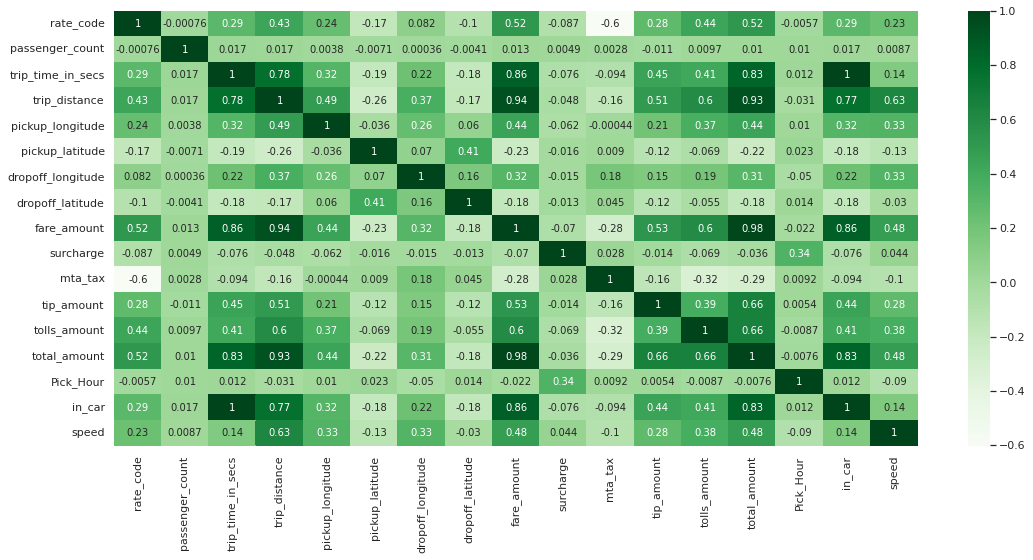

In [ ]:
################ What features influence fare and tip amounts?
taxi['speed'] = taxi['trip_distance']/taxi['trip_time_in_secs']
taxi_corr = taxi.corr()
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.heatmap(taxi_corr, annot = True, cmap='Greens')

In [ ]:
taxi3 = taxi[1:10000]

#!python -m pip install scikeras
#import scikeras
from keras.models import Sequential
from keras.layers import Dense
#from scikeras.wrappers import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

X = taxi3[['rate_code','trip_time_in_secs','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_distance','in_car']]
Y = taxi3.fare_amount
# Perceptron- Keras Regressor
def NN():
    model = Sequential()
    model.add(Dense(10, input_dim=8, kernel_initializer='random_normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='random_normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model = KerasRegressor(build_fn=NN, epochs=30, verbose=0)
results = cross_val_score(estimator=model, X=np.array(X), y=np.array(Y), cv=5)
print("MSE of NN for the predicted fare amount is %.2f (%.2f)" % (results.mean(), results.std()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


MSE of NN for the predicted fare amount is -3.68 (1.11)


In [ ]:
taxi2 = taxi[1:10000]
features=['fare_amount','rate_code','trip_time_in_secs','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_distance','in_car','passenger_count','trip_time_in_secs']
label=['fare_amount']
data2=taxi2[features]
features=['rate_code','trip_time_in_secs','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_distance','in_car','passenger_count','trip_time_in_secs']

import math
from sklearn import  metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
def modelfit(estimator,data_train,data_test,predictors,target):
    #fitting model
    estimator.fit(data_train[predictors],data_train.loc[:,target])
    #train data prediction
    train_pred=estimator.predict(data_train[predictors])
    #cross_validation score
    cv_score=cross_val_score(estimator,data_train[predictors],data_train.loc[:,target],cv=5,scoring='neg_mean_squared_error')
    cv_score=np.sqrt(np.abs(cv_score))
    #Print model report:
    print ("\nModel Report")
    print ("RMSE on Train Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_train.loc[:,target].values, train_pred)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    test_pred=estimator.predict(data_test[predictors])
    print ("RMSE on Test Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_test.loc[:,target].values, test_pred)))
    return test_pred

validation_size = 0.20
seed = 7
X_train, X_test = train_test_split(data2,test_size=validation_size, random_state=seed)
mean_pred=np.repeat(X_train[label].mean(),len(X_test[label]))
X_train.drop('fare_amount', axis=1)
X_test.drop('fare_amount', axis=1)
math.sqrt(mse(X_test[label],mean_pred))
mod = LinearRegression(normalize=True)
y_pred=modelfit(mod, X_train, X_test,features,label)
coef1 = mod.coef_[0]
print('The coeffient is {}'.format(coef1))

Model Report
RMSE on Train Data: 1.639
CV Score : Mean - 1.552 | Std - 0.6057 | Min - 0.7066 | Max - 2.953
RMSE on Test Data: 2.011
The coeffient is [ 4.47840952e+00 -2.69769940e+09  7.79703857e+08  4.73058097e+00
  1.17643082e-01 -3.34298311e+00  1.03530569e+00  1.80934742e+00
  1.86979729e-02 -1.16794095e-02  8.68032135e+08  1.04996341e+09]

> Indented block



Factors under driver's control is time & pickup location (maybe even drop off when demand is high). Factors maximizing efficiency/earning is availibility of passengers, fare amount, tips amount, availibility of passengers at drop-off locations, and specifically passengers paying with card/unk. Investgation on some of these factors:

1.   Availibility of Passengers (demand for taxi) 
  *   @ given time
  *   @ given location

2.   Fare amount according to pick up location and time

3.   Tips distribution based on:
  *   location
  *   time (hours)
  *   time (day)

4.  There should also be some analysis on consistency of routes so the drivers can decide if they want to take risks of charging with code_rate = 5.



Text(0.5, 1.0, 'Average Fare Concentration (C&O)')

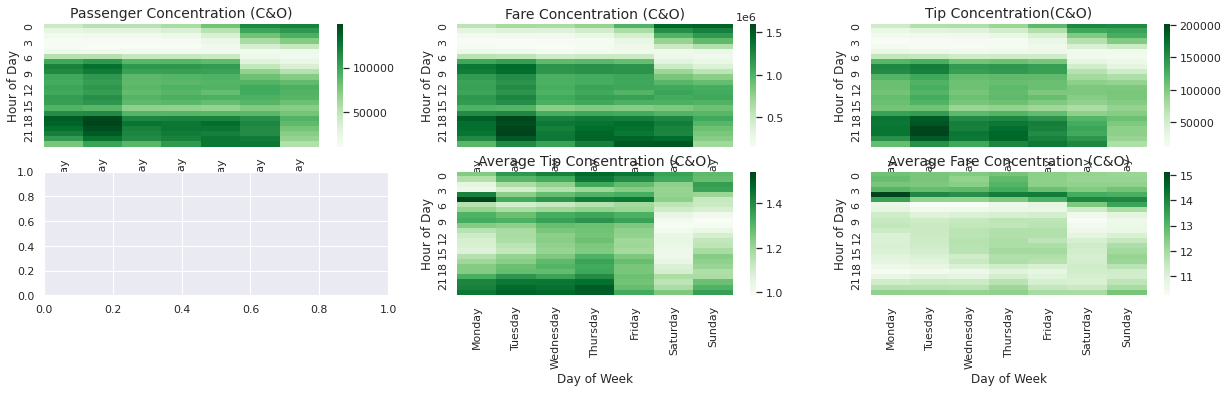

In [13]:
#@title visualize q7 city centre
############## If you were a taxi owner, how would you maximize your earnings in a day?
# What are the busiest days and hours for taxi drivers?
taxi_m = taxi[(taxi.rate_code <=1 ) | (taxi.rate_code >3 )]
pass_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['passenger_count'].size().reset_index()
pass_conc_piv = pd.pivot_table(pass_conc, values="passenger_count",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
pass_conc_piv = pass_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

fare_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['fare_amount'].sum().reset_index()
fare_conc_piv = pd.pivot_table(fare_conc, values="fare_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
fare_conc_piv = fare_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

tip_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['tip_amount'].sum().reset_index()
tip_conc_piv = pd.pivot_table(tip_conc, values="tip_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
tip_conc_piv = tip_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
#plot pivot table as heatmap using seaborn
fig, ax = plt.subplots(2,3,figsize=(21,5))
ax[0,0] = sns.heatmap(pass_conc_piv, ax=ax[0,0], cmap='Greens')
ax[0,0].set_xlabel('Day of Week', fontsize=12)
ax[0,0].set_ylabel('Hour of Day', fontsize=12)
ax[0,0].set_title('Passenger Concentration (C&O)', fontsize=14)

ax[0,1] = sns.heatmap(fare_conc_piv, ax=ax[0,1], cmap='Greens')
ax[0,1].set_xlabel('Day of Week', fontsize=12)
ax[0,1].set_ylabel('Hour of Day', fontsize=12)
ax[0,1].set_title('Fare Concentration (C&O)', fontsize=14)

ax[0,2] = sns.heatmap(tip_conc_piv, ax=ax[0,2], cmap='Greens')
ax[0,2].set_xlabel('Day of Week', fontsize=12)
ax[0,2].set_ylabel('Hour of Day', fontsize=12)
ax[0,2].set_title('Tip Concentration(C&O)', fontsize=14)

tip_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['tip_amount'].mean().reset_index()
tip_conc_piv = pd.pivot_table(tip_conc, values="tip_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
tip_conc_piv = tip_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
ax[1,1] = sns.heatmap(tip_conc_piv, ax=ax[1,1], cmap='Greens')
ax[1,1].set_xlabel('Day of Week', fontsize=12)
ax[1,1].set_ylabel('Hour of Day', fontsize=12)
ax[1,1].set_title('Average Tip Concentration (C&O)', fontsize=14)

fare_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['fare_amount'].mean().reset_index()
fare_conc_piv = pd.pivot_table(fare_conc, values="fare_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
fare_conc_piv = fare_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
ax[1,2] = sns.heatmap(fare_conc_piv, ax=ax[1,2], cmap='Greens')
ax[1,2].set_xlabel('Day of Week', fontsize=12)
ax[1,2].set_ylabel('Hour of Day', fontsize=12)
ax[1,2].set_title('Average Fare Concentration (C&O)', fontsize=14)

Text(0.5, 1.0, 'Tip Concentration (A) ')

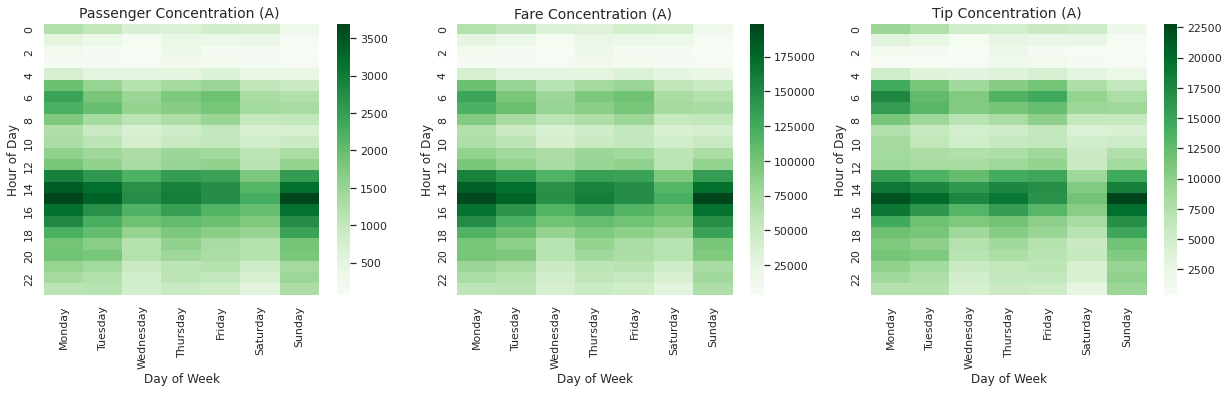

In [14]:
############## If you were a taxi owner, how would you maximize your earnings in a day?
# What are the busiest days and hours for taxi drivers?
taxi_m = taxi[(taxi.rate_code <=1 ) | (taxi.rate_code >3 )]
taxi_m = taxi[(taxi.rate_code ==3 ) | (taxi.rate_code ==2 )]
a = " (A) "
pass_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['passenger_count'].size().reset_index()
pass_conc_piv = pd.pivot_table(pass_conc, values="passenger_count",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
pass_conc_piv = pass_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

fare_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['fare_amount'].sum().reset_index()
fare_conc_piv = pd.pivot_table(fare_conc, values="fare_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
fare_conc_piv = fare_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

tip_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['tip_amount'].sum().reset_index()
tip_conc_piv = pd.pivot_table(tip_conc, values="tip_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
tip_conc_piv = tip_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
#plot pivot table as heatmap using seaborn
fig, ax = plt.subplots(1,3,figsize=(21,5))
ax[0] = sns.heatmap(pass_conc_piv, ax=ax[0], cmap='Greens')
ax[0].set_xlabel('Day of Week', fontsize=12)
ax[0].set_ylabel('Hour of Day', fontsize=12)
ax[0].set_title('Passenger Concentration'+a, fontsize=14)

ax[1] = sns.heatmap(fare_conc_piv, ax=ax[1], cmap='Greens')
ax[1].set_xlabel('Day of Week', fontsize=12)
ax[1].set_ylabel('Hour of Day', fontsize=12)
ax[1].set_title('Fare Concentration'+a, fontsize=14)

ax[2] = sns.heatmap(tip_conc_piv, ax=ax[2], cmap='Greens')
ax[2].set_xlabel('Day of Week', fontsize=12)
ax[2].set_ylabel('Hour of Day', fontsize=12)
ax[2].set_title('Tip Concentration'+a, fontsize=14)

Text(0.5, 1.0, 'Average Fare Concentration (C&O) ')

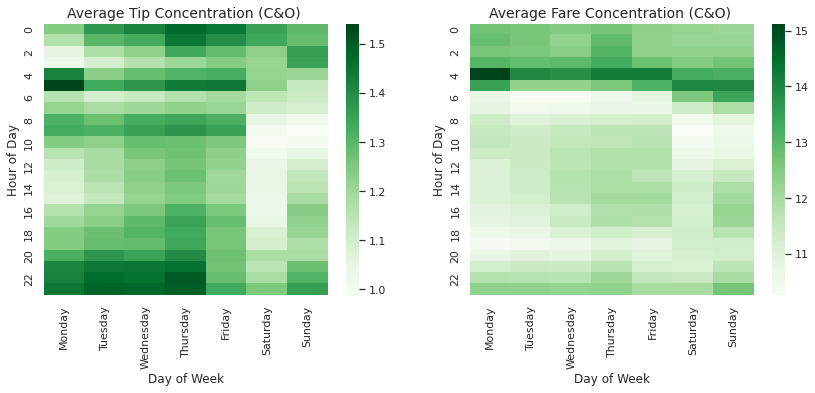

In [17]:
taxi_m = taxi[(taxi.rate_code <=1 ) | (taxi.rate_code >3 )]
#taxi_m = taxi[(taxi.rate_code ==3 ) | (taxi.rate_code ==2 )]
a = " (C&O) "
fig, ax = plt.subplots(1,2,figsize=(14,5))
tip_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['tip_amount'].mean().reset_index()
tip_conc_piv = pd.pivot_table(tip_conc, values="tip_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
tip_conc_piv = tip_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
ax[0] = sns.heatmap(tip_conc_piv, ax=ax[0], cmap='Greens')
ax[0].set_xlabel('Day of Week', fontsize=12)
ax[0].set_ylabel('Hour of Day', fontsize=12)
ax[0].set_title('Average Tip Concentration'+a, fontsize=14)

fare_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['fare_amount'].mean().reset_index()
fare_conc_piv = pd.pivot_table(fare_conc, values="fare_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
fare_conc_piv = fare_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
ax[1] = sns.heatmap(fare_conc_piv, ax=ax[1], cmap='Greens')
ax[1].set_xlabel('Day of Week', fontsize=12)
ax[1].set_ylabel('Hour of Day', fontsize=12)
ax[1].set_title('Average Fare Concentration'+a, fontsize=14)

7. If you were a taxi owner, how would you maximize your earnings in a day?

Its sustainable to work for about 12 hours a day preferably with 8 continuous hours for sleep according to the day. 

All types of paymentsI'll accept both cash and card payments to attract as many 

1.   Accept all types of payments to be able to have more demand but incentivise card payment by explicitly presenting the option at the start of the ride.
2.  Tip amount is positively correlated with speed so, in alternate routes with similar trip durations, choose longer routes for higher speed.

3. Airport fares bring 3-4 times fare in the city so its okay to have longer wait times there. Also tips are higher.

4. Strategize location with time: Manhattan Centre vs. Airport. vs Outskirts.


Sun: 0am-3am in city latenight service (demand is good). 10am-7pm airport demand is there and good tip and fare amounts.

Monday-Thursay: Data indicates passenger availability in Manhatattan is from 8a.m. to 10am and 6pm to 11pm. 1-5pm there is high demand for airport rides. 12p.m.-4p.m. passenger demand is high and average fare >50 dollars. Although passenger availability in Manhattan is not high from 3-5am, there is high incentive as tips and the same applies for Airports, however, it is much more profitable to be at the airport in this slot although demand is lower (12000-17000 trips vs 32000 available taxis). So this is an option if one wants to ride over 12 hours. 

5. In general Tuesdays have more demand than other week days.

Friday: Data indicates passenger availability in Manhatattan is from 8a.m. to 10am and 6pm to 12pm. 1-5pm there is high demand for airport rides. 12p.m.-4p.m. passenger demand is high and average fare >50 dollars.

Saturday: Be in the city from 12a.m. to 3a.m., 10a.m. to 1p.m. and from 6p.m. 12a.m.


Text(0.5, 1.0, 'Average Fare Concentration (A)')

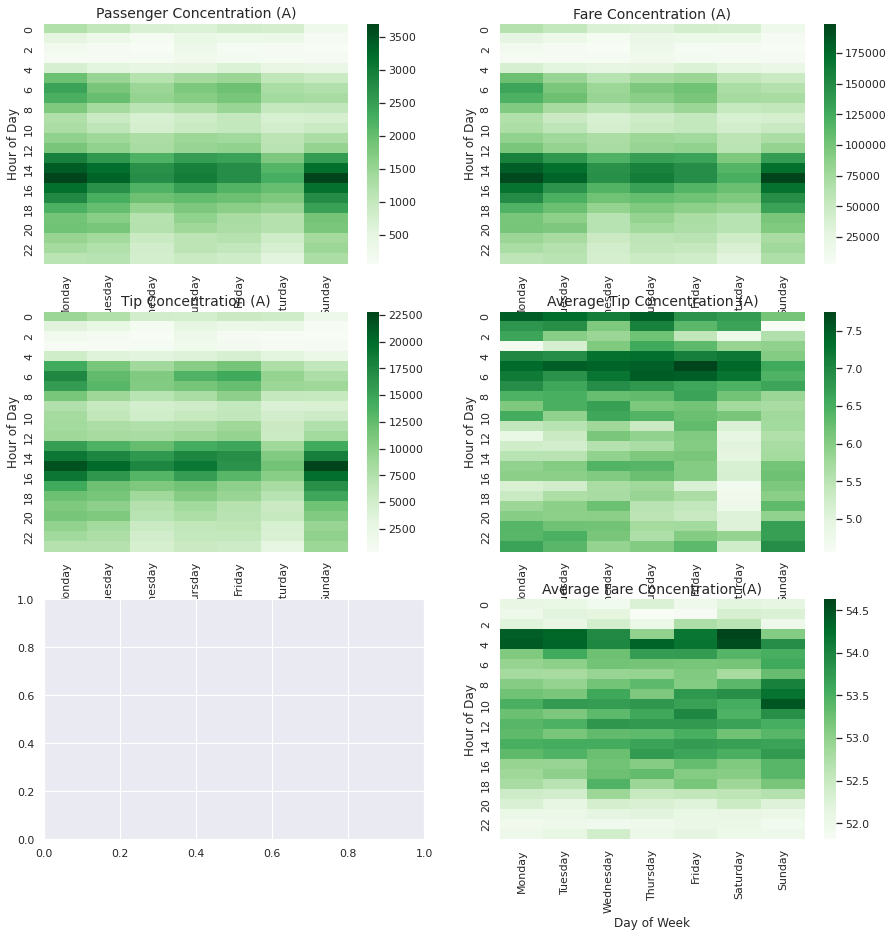

In [4]:

############## If you were a taxi owner, how would you maximize your earnings in a day?
# What are the busiest days and hours for taxi drivers?
taxi_m = taxi[(taxi.rate_code ==3 ) | (taxi.rate_code ==2 )]
pass_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['passenger_count'].size().reset_index()
pass_conc_piv = pd.pivot_table(pass_conc, values="passenger_count",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
pass_conc_piv = pass_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

fare_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['fare_amount'].sum().reset_index()
fare_conc_piv = pd.pivot_table(fare_conc, values="fare_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
fare_conc_piv = fare_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

tip_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['tip_amount'].sum().reset_index()
tip_conc_piv = pd.pivot_table(tip_conc, values="tip_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
tip_conc_piv = tip_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
#plot pivot table as heatmap using seaborn
fig, ax = plt.subplots(3,2,figsize=(15,15))
ax[0,0] = sns.heatmap(pass_conc_piv, ax=ax[0,0], cmap='Greens')
ax[0,0].set_xlabel('Day of Week', fontsize=12)
ax[0,0].set_ylabel('Hour of Day', fontsize=12)
ax[0,0].set_title('Passenger Concentration (A)', fontsize=14)

ax[0,1] = sns.heatmap(fare_conc_piv, ax=ax[0,1], cmap='Greens')
ax[0,1].set_xlabel('Day of Week', fontsize=12)
ax[0,1].set_ylabel('Hour of Day', fontsize=12)
ax[0,1].set_title('Fare Concentration (A)', fontsize=14)

ax[1,0] = sns.heatmap(tip_conc_piv, ax=ax[1,0], cmap='Greens')
ax[1,0].set_xlabel('Day of Week', fontsize=12)
ax[1,0].set_ylabel('Hour of Day', fontsize=12)
ax[1,0].set_title('Tip Concentration (A)', fontsize=14)

tip_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['tip_amount'].mean().reset_index()
tip_conc_piv = pd.pivot_table(tip_conc, values="tip_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
tip_conc_piv = tip_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
ax[1,1] = sns.heatmap(tip_conc_piv, ax=ax[1,1], cmap='Greens')
ax[1,1].set_xlabel('Day of Week', fontsize=12)
ax[1,1].set_ylabel('Hour of Day', fontsize=12)
ax[1,1].set_title('Average Tip Concentration (A)', fontsize=14)

fare_conc = taxi_m.groupby(['DayofWeek','Pick_Hour'])['fare_amount'].mean().reset_index()
fare_conc_piv = pd.pivot_table(fare_conc, values="fare_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
fare_conc_piv = fare_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
ax[2,1] = sns.heatmap(fare_conc_piv, ax=ax[2,1], cmap='Greens')
ax[2,1].set_xlabel('Day of Week', fontsize=12)
ax[2,1].set_ylabel('Hour of Day', fontsize=12)
ax[2,1].set_title('Average Fare Concentration (A)', fontsize=14)

In [ ]:
fac = 2
pickup_latitude = taxi.pickup_latitude.round(fac)
pickup_longitude = taxi.pickup_longitude.round(fac)
dropoff_latitude = taxi.dropoff_latitude.round(fac)
dropoff_longitude = taxi.dropoff_longitude.round(fac)

# What are the locations by hours for taxi drivers?
trip_pickup_group = taxi.groupby(['pickup_latitude','pickup_longitude'])['passenger_count'].size().reset_index()
trip_dropoff_group = taxi.groupby(['dropoff_latitude','dropoff_longitude'])['passenger_count'].size().reset_index()

trip_pickup_time = taxi.groupby(['pickup_latitude','pickup_longitude'])['trip_time_in_secs'].size().reset_index()

tip_conc = taxi.groupby(['DayofWeek','Pick_Hour'])['tip_amount'].size().reset_index()
tip_conc_piv = pd.pivot_table(tip_conc, values="tip_amount",index=["Pick_Hour"], columns=["DayofWeek"], fill_value=0)
tip_conc_piv = tip_conc_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
#plot pivot table as heatmap using seaborn
fig, ax = plt.subplots((1,3),figsize=(5,5))
ax[0] = sns.heatmap(pass_conc_piv, ax=ax, cmap='Greens')
ax[0].set_xlabel('Day of Week', fontsize=12)
ax[0].set_ylabel('Hour of Day', fontsize=12)
ax[0].set_title('Passenger Concentration', fontsize=14)

ax[1] = sns.heatmap(fare_conc_piv, ax=ax, cmap='Greens')
ax[1].set_xlabel('Day of Week', fontsize=12)
ax[1].set_ylabel('Hour of Day', fontsize=12)
ax[1].set_title('Fare Concentration', fontsize=14)

ax[2] = sns.heatmap(tip_conc_piv, ax=ax, cmap='Greens')
ax[2].set_xlabel('Day of Week', fontsize=12)
ax[2].set_ylabel('Hour of Day', fontsize=12)
ax[2].set_title('Tip Concentration', fontsize=14)

##############

8. If you run a taxi company with 10 taxis, how would you maximize your earnings?


*   Ideal time for taxi maintainance is 2-4 am ( poor fares, low demand because of overalll low fare) on weekdays and 3a.m.-4a.m. on weekends (due to airport). 
*   Given that the city is densely populated and that there is a really high demand for taxis in Manhattan, its alright for all taxis to be present within this area from 8 a.m. to 1 a.m. (17 hours)-low risk and low wastage of petrol and free time. I don't expect them to get in each other's way unless one or more taxis have a big wait time in between trips.

*   Airport trips are high income trips since in one trip 52 dollars is min income and recommended/can have incentives between 1p.m. and 3p.m.. Moreover, tip amount is high.
*   All reseouces need to be employed on weekday evenings from 8-10 am and 5p.m. to 9p.m. especially Tuesday the whole day in the Manhattan area.

*   No need to assign taxis for airport trips on Saturday, all for city.

*   Need not invest in big vehicles since 89.506 % trips have <= 4 passengers. Its also faster in traffic.

*   Speed of taxi is positively correlated with tip amount so its worth travelling is less conjested routes (also longer distances increase fare).

*   From 10am to 1 p.m. on weekdays -> hospitals, old age homes, senior citizen travel (Good Friday, Easter Sunday and easter Monday. )

*   Keep track of conventions during the day, events( concerts etc. esp alcohol serving venues at night).

*   Card customers pay more tip than cash customers. The location analysis shows that the card payers are likely to be more spread out in the pick up and drop off locations and there is always more chance in every hour to pick up a card customer rather than a cash customer. So it is always beneficial to go accept the rider.


Differentiating factor of my company from other companies: accept only card payment, focus on speed (offering discounted fare) and smaller cars for smaller no. of passengers and airport taxi service for business trips. 

To minimize undercutting:
1). Unsupervised clusters of trips. Each cluster marks an area hexagon. Pick 10 distinct distributed spots in areas according to traffic. First come first serve basis assignment.







In [ ]:
###### tip by payment type
count = taxi.groupby(['payment_type'])['tip_amount'].count().reset_index()
tip_conc = taxi.groupby(['payment_type'])['tip_amount'].mean().reset_index()
tip_conc['noOfTrips'] = count['tip_amount']
tip_conc.head()

######### Passenger count
count = taxi.groupby(['passenger_count'])['medallion'].count().reset_index(name='trip_count')
count['trip_count'] = count['trip_count']/count['trip_count'].sum()

########## Card locations vs. cash location
fac = 2
taxi.pickup_latitude = taxi.pickup_latitude.round(fac)
taxi.pickup_longitude = taxi.pickup_longitude.round(fac)
taxi.dropoff_latitude = taxi.dropoff_latitude.round(fac)
taxi.dropoff_longitude = taxi.dropoff_longitude.round(fac)

taxi2 = taxi[['pickup_latitude','pickup_longitude','payment_type']]
taxi3 = taxi2[(taxi2['payment_type']=="CSH")|(taxi2['payment_type']=="NOC")]
taxi2 = taxi2[(taxi2['payment_type']=="CRD")|(taxi2['payment_type']=="UNK")]
taxi2 = taxi2.groupby(['pickup_latitude','pickup_longitude'])['payment_type'].count().reset_index(name='freq')
taxi3 = taxi3.groupby(['pickup_latitude','pickup_longitude'])['payment_type'].count().reset_index(name='freq')
BBox = (-75,   -72,  39.6, 42)
ruh_m = plt.imread(path+'map.png')
from matplotlib.pyplot import figure
figure(figsize=(4,4), dpi=180)
plt.scatter(taxi2.pickup_longitude, taxi2.pickup_latitude, zorder=1, alpha= 0.2, c=taxi2.freq, s=5, cmap ='autumn')
plt.scatter(taxi3.pickup_longitude, taxi3.pickup_latitude, zorder=1, alpha= 0.2, c=taxi3.freq, s=2, cmap ='summer')
plt.title('Pick-up location card payers (red) vs cash payers(green)', fontsize=12)
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

taxi2 = taxi[['dropoff_latitude','dropoff_longitude','payment_type']]
taxi3 = taxi2[(taxi2['payment_type']=="CSH")|(taxi2['payment_type']=="NOC")]
taxi2 = taxi2[(taxi2['payment_type']=="CRD")|(taxi2['payment_type']=="UNK")]
taxi2 = taxi2.groupby(['dropoff_latitude','dropoff_longitude'])['payment_type'].count().reset_index(name='freq')
taxi3 = taxi3.groupby(['dropoff_latitude','dropoff_longitude'])['payment_type'].count().reset_index(name='freq')
BBox = (-75,   -72,  39.6, 42)
ruh_m = plt.imread(path+'map.png')
from matplotlib.pyplot import figure
figure(figsize=(4,4), dpi=180)
plt.scatter(taxi2.dropoff_longitude, taxi2.dropoff_latitude, zorder=1, alpha= 0.2, c=taxi2.freq, s=5, cmap ='autumn')
plt.scatter(taxi3.dropoff_longitude, taxi3.dropoff_latitude, zorder=1, alpha= 0.2, c=taxi3.freq, s=2, cmap ='summer')
plt.title('Dropoff location card payers (red) vs cash payers(green)', fontsize=12)
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

########## Card pick hour vs. cash pick hour
taxi2 = taxi[['Pick_Hour','payment_type']]
taxi3 = taxi2[(taxi2['payment_type']=="CSH")|(taxi2['payment_type']=="NOC")]
taxi2 = taxi2[(taxi2['payment_type']=="CRD")|(taxi2['payment_type']=="UNK")]
taxi2 = taxi2.groupby(['Pick_Hour'])['payment_type'].count().reset_index(name='freq').plot.bar(title='Card/unk')
taxi3 = taxi3.groupby(['Pick_Hour'])['payment_type'].count().reset_index(name='freq').plot.bar(title='Cash/NoC')

9. What possible issues in the data might impact your approach?


*   Some genuine data like tip of $400 dollars for a short distance is unusual behaviour and these outliers hinder learning of normal trends.

*   There is no explicit information on the working hours of the drivers( it is assumed here that the drivers are working only when they pick-up to drop off). So its hard to estimate the resource available/wasted.
*   Similarly there is no prior information on the demand i.e. availability of passengers and that needs to be assumed from the #of trips. (but its also a possibility that the regions of high concentration of trips is boosted by an equlibrium between the passengers availability and the taxi resource availibility).
*   Need to scrub data with more detail. E.g. locations in sea.
*   There is no way of checking the trip distance (crucial param) entered except for it cannot be < "crow flies" distance between pick up and drop off- basically data uncertainty maybe high.
*   Similarly there may be incorrect entries that can lead to misclassification, E.g. tip amount, longitude and latitudes, trip time, entered may be incorrect.

*   It would be beneficial to have a wait time column and the wait amount since there seems to be a large discrepency between the duration inside the car and the trip duration.




10. What are the potential drawbacks to using the selected model? What other models might be useful?

- A neural network is not needed to fit a linear regression model, simpler regression models can be used - way lower complexity.

- Also its hard to know underlying mechanisms by which the not so obvious columns ('rate_code') are contributing to the predicted fare when using an NN because we dont have a relationship between columns as output.
- My nn model is too simple atm, without any hyperparameter training/regularization, batch normalization etc. due to memory and time constraints, which is an indication of how costly this complex model can be and improve it. 
- Moreover, since this model is not deterministic, there is going to be model uncertainty which needs to be characterized with MC methods or variational inference etc., which is very expensive or mathematically intensive respectively.
- Then why did I choose NN? Cuz most models e.g. linear regression etc can't make use of all the columns that NN might be able to make.
- Since the option of using NN is avaialable and with a GPu/ HPC resources, I'd have included the "hourly engaged", week day data, 'public holiday'. However, since 4 samples are available for week day more months' data may be included to have better training with a wider-deeper model structure.
- Some trips may be temporally correlated e.g. tourists hopping from one stop to another so there need to be a model (Markov process or kalman filtering) taking that into account. 